# BOILER PLATE CODE, DO NOT AMEND
**\<BOILER PLATE CODE>**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv("https://drive.google.com/uc?id=1MdBJ_nD4H_IPFqQGCymTOilBfKHIKlAB&export=download", sep='\t', header=0)
print("Number of is_duplicated row percentage:", df["is_duplicate"].mean())
df.head(5)

Number of is_duplicated row percentage: 0.3693265832247709


id    qid1    qid2                                          question1  \
0  133273  213221  213222  How is the life of a math student? Could you d...   
1  402555  536040  536041                How do I control my horny emotions?   
2  360472  364011  490273       What causes stool color to change to yellow?   
3  150662  155721    7256                        What can one do after MBBS?   
4  183004  279958  279959  Where can I find a power outlet for my laptop ...   

                                           question2  is_duplicate  
0  Which level of prepration is enough for the ex...             0  
1                 How do you control your horniness?             1  
2  What can cause stool to come out as little balls?             0  
3                       What do i do after my MBBS ?             1  
4  Would a second airport in Sydney, Australia be...             0

**\<\BOILER PLATE CODE>**

In [ ]:
df.groupby("is_duplicate")["id"].count()

is_duplicate
0    229468
1    134378
Name: id, dtype: int64

In [ ]:
df.shape

(363846, 6)

**COPY DF BEFORE MAKING PERSONAL MODIFICATIONS**

Eg.
```
dfRawYuXin = df.copy()
dfProcessed = dfRawYuXin ...

```

---

# Quick analysis of data

### NaN in the dataset
This will give an overview on the amount of NaN in the dataset. 

In [ ]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

### Distribution of is_duplicate

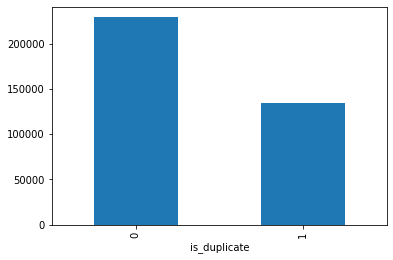

In [ ]:
df.groupby("is_duplicate")["id"].count().plot.bar()

### Collate all the questions into a qnBank, in order to do operations on it easily


Number of unique question: 494385
Number of questions that appear more than once: 98740
Number of question that only appears once: 395645


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


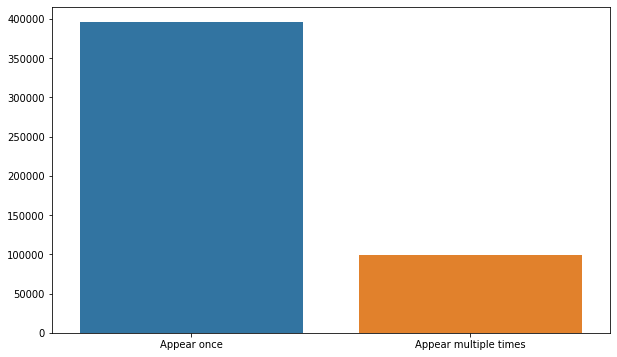

In [ ]:
qn1 = df[["qid1", "question1"]].rename(columns={"qid1": "qid", "question1": "question"})
qn2 = df[["qid2", "question2"]].rename(columns={"qid2": "qid", "question2": "question"})
qnBank = qn1.append(qn2, sort=lambda x: x["qid"])

print("Number of unique question:", len(np.unique(qnBank["qid"])))
print("Number of questions that appear more than once:", np.sum(qnBank["qid"].value_counts() > 1))
print("Number of question that only appears once:", np.sum(qnBank["qid"].value_counts() == 1))

x = ["Appear once" , "Appear multiple times"]
y =  [np.sum(qnBank["qid"].value_counts() == 1) , np.sum(qnBank["qid"].value_counts() > 1)]

plt.figure(figsize=(10, 6))
sns.barplot(x,y)
plt.show()

### Check if the link bwetween questionId and question is unique

In [ ]:
# Check if there is more than 1 question with same ID
idWithDifferentQuestion = np.sum(qnBank.groupby("qid")['question'].nunique() > 1)
print("Number of id that is linked to more than 1 question:", idWithDifferentQuestion)

# Check if there is more than 1 id with same question
idWithDifferentQuestion = np.sum(qnBank.groupby("question")['qid'].nunique() > 1)
print("Number of question that is linked to more than 1 id:", idWithDifferentQuestion)

Number of id that is linked to more than 1 question: 0
Number of question that is linked to more than 1 id: 475


### Categorise the questions by their starting words and 5W1H

In [ ]:
startingWords = {}
word5w1h = {
    "who": 0,
    "what": 0,
    "why": 0,
    "when": 0,
    "where": 0,
    "how": 0,
    "others": 0
}

qnBankWords = []

def findStartingWord(string):
    string = word_tokenize(string.lower())
    if string[0] not in startingWords:
        startingWords[string[0]] = 0
    startingWords[string[0]] += 1

def find5W1H(string):
    words = ["who", "what", "why", "when", "where", "how"]

    string = string.lower()
    isUpdated = False
    for word in words:
        if len(string.split(word)) > 1:
            word5w1h[word] += 1
            isUpdated = True
     
    if not isUpdated:
        word5w1h["others"] += 1


        

qnBank = qnBank.dropna()
qnBank["question"].apply(findStartingWord)

print("Highest number of starting wrd")
print(sorted(startingWords.items(), key=lambda x: x[1], reverse=True)[:20])
print()
print("5W1H")
print(word5w1h)

Highest number of starting wrd
[('what', 255925), ('how', 168970), ('why', 58439), ('is', 41195), ('which', 30961), ('can', 20943), ('i', 19094), ('who', 13971), ('do', 12319), ('where', 11853), ('if', 10975), ('does', 9020), ('are', 8227), ('should', 5828), ('when', 5748), ('will', 5555), ('in', 3444), ('my', 3416), ('did', 2248), ('would', 2090)]

5W1H
{'who': 0, 'what': 0, 'why': 0, 'when': 0, 'where': 0, 'how': 0, 'others': 0}


### Get a sample and manually check it
Might have better way of verification but I'm just leaving it as such for now

In [ ]:
n = 20
actual = 0
sampleDf = df.sample(n=n)

def sample(row):
    global actual

    print("Qn1", row["question1"])
    print("Qn2", row["question2"])

    inp = input("Is this the same? (y/n): ")
    inp = 1 if inp == "y" else 0
    print()

    if inp == row["is_duplicate"]:
        actual += 1
    
sampleDf.apply(sample, axis=1)

print("=" * 50)
print("Total correctly labelled", actual)
print("Percentage correct", actual / n)

Qn1 What can I do to have a better chance of getting accepted into an Ivy League school?
Qn2 What can I do to get accepted into an Ivy League school?
Is this the same? (y/n): y

Qn1 Which firewall is best for small to medium sized network?
Qn2 Did your father fight in the Korean War?
Is this the same? (y/n): n

Qn1 What are the differences between Islamic lifestyle and American lifestyle?
Qn2 What are the differences between Islamic lifestyle and Western lifestyle?
Is this the same? (y/n): y

Qn1 In the film La La Land, does Ryan Gosling actually play any of the instruments?
Qn2 What is the movie La La Land about?
Is this the same? (y/n): n

Qn1 What hotel in Gwalior would be safe for unmarried couples, without the harassment of police, hotel staff, and moral police?
Qn2 What hotel in Jaipur would be safe for unmarried couples, without the harassment of police, hotel staff, and moral police?
Is this the same? (y/n): n

Qn1 Who is the smartest in the strawhats?
Qn2 How does Hillary Clin

---

# This section cleans the data for encoding purpose. It will create a separate dataframe for use with encoding. 

Steps to be done:

*   Removing of low occurance words 
  *    Rationale: It is hypothesized that low occurance words are likely to by misspelling or numbers and do not add additional information to the encoding, only contributing noise.
*   Removing of very high occurance words
  *    Rationale: It is hypothesized that high occurance words such as 'the', 'is' do not add much meaning to the sentence and can be removed without changing semantic meaning of the sentence.

*   Stemming of words
  *    Stemming of words convert similar words into the same base form. This simplifies the encoding vector and result in less dimensionality while preserving meaning.

Inspired by: https://uc-r.github.io/creating-text-features


In [ ]:
# Installs tidytext, a python port of a package from R
!pip install tidytext
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 206 kB 33.7 MB/s 
  Created wheel for tidytext: filename=tidytext-0.0.1-py3-none-any.whl size=3894 sha256=15087904f2119682f17add891114b9480ddd13c12b3db9eab509c5f0f8411750
  Stored in directory: /root/.cache/pip/wheels/46/3e/22/58c2c48258386098001ea3ef7652b69b6050fbcaa6b7adb9d7
Successfully built tidytext


## The following code finds all the unique words in the qnBank data set and their frequency.

In [ ]:
# Generously copied from stackoverflow with edits
processedData = pd.Series(' '.join(qnBank.question.apply(lambda x : ''.join(filter(lambda y: y.isalpha() or y.isspace(), x)).lower())).split())
wordFreq = processedData.value_counts()

In [ ]:
processedData

0             how
1              is
2             the
3            life
4              of
            ...  
7947116         i
7947117      earn
7947118     money
7947119    online
7947120    easily
Length: 7947121, dtype: object

In [ ]:
# Most frequent words
wordFreq[:10]

the     339746
what    280301
is      242588
how     198513
i       193791
a       190410
to      184905
in      176977
do      144832
of      143819
dtype: int64

In [ ]:
# Least frequent words
wordFreq[-10:]

presoak        1
kirorimal      1
harryron       1
csecould       1
atquickexit    1
practioners    1
hornbill       1
ghengis        1
muskrat        1
boling         1
dtype: int64

### As we can see, the histogram is dominated by low occurance words, 

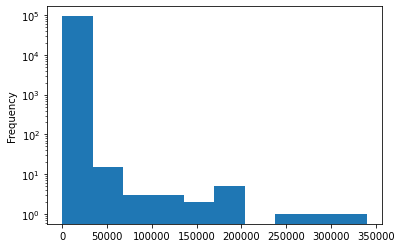

In [ ]:
wordFreq.plot.hist(logy=True)

## Only allowing for words with occurance of more than 10 times helps to reduce the number of words by a factor of 10

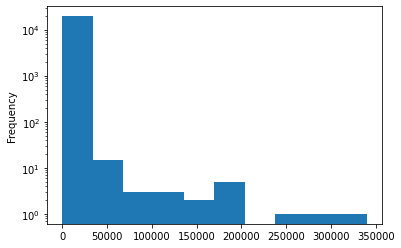

In [ ]:
wordFreqCutoff = wordFreq.loc[lambda x : x >= 10]
wordFreqCutoff.plot.hist(logy=True)

In [ ]:
wordFreqCutoff[-10:]

smes              10
ditched           10
yousafzai         10
websockets        10
microservices     10
drastic           10
uscanada          10
psychoanalysis    10
tinted            10
quesitons         10
dtype: int64

In [ ]:
print('Number of unique words before filtering for words that only appear more than 10 times', wordFreq.count())
print('Number of unique words after filtering for words that only appear more than 10 times', wordFreqCutoff.count())


Number of unique words before filtering for words that only appear more than 10 times 94526
Number of unique words after filtering for words that only appear more than 10 times 19608


## Next, we will try stemming of the words to further reduce the number of unique words.

In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


In [ ]:
# warning: takes a while to process
stemmedData = processedData.apply(lambda x : stemmer.stem(x))

In [ ]:
wordFreqStemmed = stemmedData.value_counts()

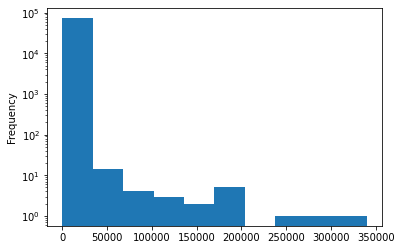

In [ ]:
wordFreqStemmed.plot.hist(logy=True)

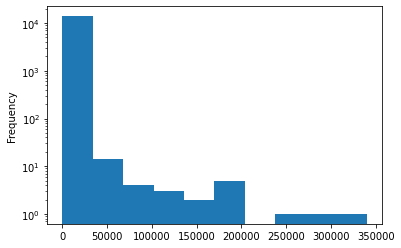

In [ ]:
wordFreqStemmedCutoff = wordFreqStemmed.loc[lambda x : x >= 10]
wordFreqStemmedCutoff.plot.hist(logy=True)

In [ ]:
print('Number of unique words after stemming and before filtering for words that only appear more than 10 times', wordFreqStemmed.count())
print('Number of unique words after stemming and after filtering for words that only appear more than 10 times', wordFreqStemmedCutoff.count())

Number of unique words after stemming and before filtering for words that only appear more than 10 times 72701
Number of unique words after stemming and after filtering for words that only appear more than 10 times 13943


In [ ]:
stemmer.stem('depressed')

'depress'

---
# Add in the eda for the respective analysis here

#H1: Cosine Similarity on the original raw sentence embeddings is good enough (acc = 90%+) to predict whether 2 questions are duplicates. 


# H2: Cosine Similarity on the truncated [till first punctuation] sentence embeddings is good enough (acc = 90%+) to predict whether 2 questions are duplicates. 

In [ ]:
dftc = df.copy()

In [ ]:
dftc.question1 = dftc.question1.str.lower()
dftc.question2 = dftc.question2.str.lower()

In [ ]:
qn1 = dftc.question1.str.split('?').str[0]
qn2 = dftc.question2.str.split('?').str[0]

In [ ]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
from scipy.spatial.distance import cosine

In [ ]:
sim = []
for q1, q2 in zip(list(qn1[:50000]), list(qn2[:50000])):
    sim.append(1 - cosine(model.encode([q1])[0], model.encode([q2])[0]))

In [ ]:
similarity = pd.Series(sim)

In [ ]:
sim_df = pd.concat([dftc.is_duplicate[:50000], similarity], axis=1)

In [ ]:
sim_df = sim_df.rename(columns={0: 'similarity'})

In [ ]:
sim_df.groupby(['is_duplicate']).describe()

similarity                                                    \
                  count      mean       std       min       25%       50%   
is_duplicate                                                                
0               31403.0  0.680110  0.206457 -0.112407  0.547558  0.716736   
1               18597.0  0.870035  0.105492  0.251782  0.817203  0.896688   

                             
                   75%  max  
is_duplicate                 
0             0.846342  1.0  
1             0.950291  1.0

In [ ]:
sim_df.is_duplicate.value_counts()

0    31403
1    18597
Name: is_duplicate, dtype: int64

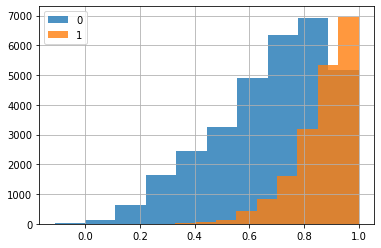

In [ ]:
sim_df.groupby(['is_duplicate']).similarity.hist(alpha=0.8)
plt.legend(sim_df.is_duplicate)

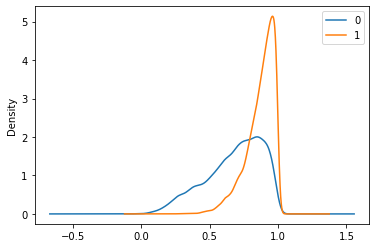

In [ ]:
sim_df.groupby(['is_duplicate']).similarity.plot.density()
plt.legend(sim_df.is_duplicate)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


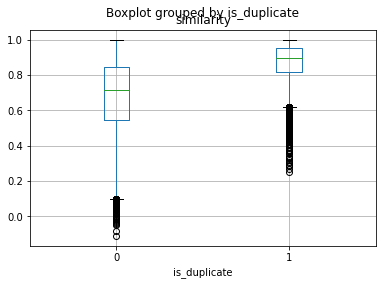

In [ ]:
sim_df.boxplot(column='similarity', by='is_duplicate')

In [ ]:
from   sklearn.feature_extraction.text import CountVectorizer

In [ ]:
count_vectorizer = CountVectorizer()

In [ ]:
sim2 = []
for q1, q2 in (zip(list(qn1[:10000]), list(qn2[:10000]))):
    document = [q1, q2]
    matrix = count_vectorizer.fit_transform(document).todense()
    sim2.append(1 - cosine(matrix[0], matrix[1]))

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [ ]:
similarity2 = pd.Series(sim2)
sim2_df = pd.concat([dftc.is_duplicate[:10000], similarity2], axis=1)

In [ ]:
sim2_df = sim2_df.rename(columns={0: 'similarity'})

In [ ]:
sim2_df.groupby(['is_duplicate']).describe()

similarity                                               \
                  count      mean       std  min       25%       50%   
is_duplicate                                                           
0                6283.0  0.430232  0.265915  0.0  0.223607  0.402015   
1                3717.0  0.621698  0.193806  0.0  0.472456  0.617213   

                             
                   75%  max  
is_duplicate                 
0             0.625000  1.0  
1             0.771517  1.0

In [ ]:
sim2_df.is_duplicate.value_counts()

0    6283
1    3717
Name: is_duplicate, dtype: int64

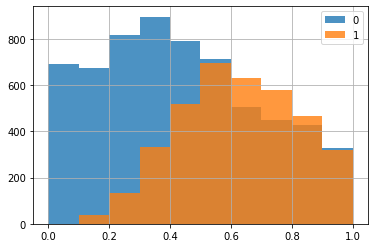

In [ ]:
sim2_df.groupby(['is_duplicate']).similarity.hist(alpha=0.8)
plt.legend(sim2_df.is_duplicate)

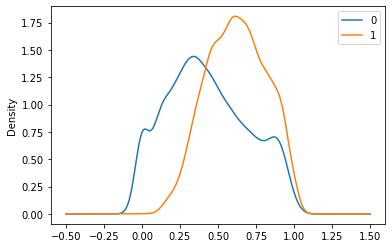

In [ ]:
sim2_df.groupby(['is_duplicate']).similarity.plot.density()
plt.legend(sim2_df.is_duplicate)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


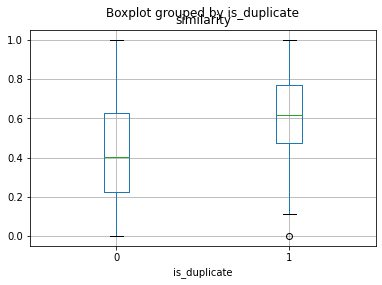

In [ ]:
sim2_df.boxplot(column='similarity', by='is_duplicate')

#H3: Cosine Similarity on the stemmed sentence embeddings is good enough (acc = 90%+) to predict whether 2 questions are duplicates. 


#H5: Questions that are duplicates have a high percent of similar bag-of-words (remove stopwords first, perhaps?)


To validate: Use set of words then check intersection. Use intersection / union as normalised result. Find mean and variance of both duplicate and non duplicate. Probs draw violin plot to see distribution

Run on two different case:
- All tokenised words
- All tokenised words without stopwords

Criteria:
- Mean is away from the 25% to 75% of the others (away from interquartile range)

1) All tokenise words

This analyse the number of common words

In [ ]:
h4Df = df.copy()

def getSimilarWords(row):
    qn1 = row['question1'].lower()
    qn2 = row['question2'].lower()

    qn1Word = set(word_tokenize(qn1))
    qn2Word = set(word_tokenize(qn2))
    
    return len(qn1Word & qn2Word) / (len(qn1Word) + len(qn2Word))

h4Df["normalised_words_shared"] = h4Df.apply(getSimilarWords, axis=1)

Finding mean and variance

In [ ]:
h4DfDuplicate = h4Df[h4Df['is_duplicate'] == 1]
h4DfNoDuplicate = h4Df[h4Df['is_duplicate'] == 0]

print("Duplicate")
print(h4DfDuplicate["normalised_words_shared"].describe())
print()
print("Not duplicate")
print(h4DfNoDuplicate["normalised_words_shared"].describe())

Duplicate
count    134378.000000
mean          0.323786
std           0.085475
min           0.071429
25%           0.260870
50%           0.320000
75%           0.388889
max           0.500000
Name: normalised_words_shared, dtype: float64

Not duplicate
count    229468.000000
mean          0.232835
std           0.120542
min           0.000000
25%           0.139535
50%           0.214286
75%           0.320000
max           0.500000
Name: normalised_words_shared, dtype: float64


General shape of the data

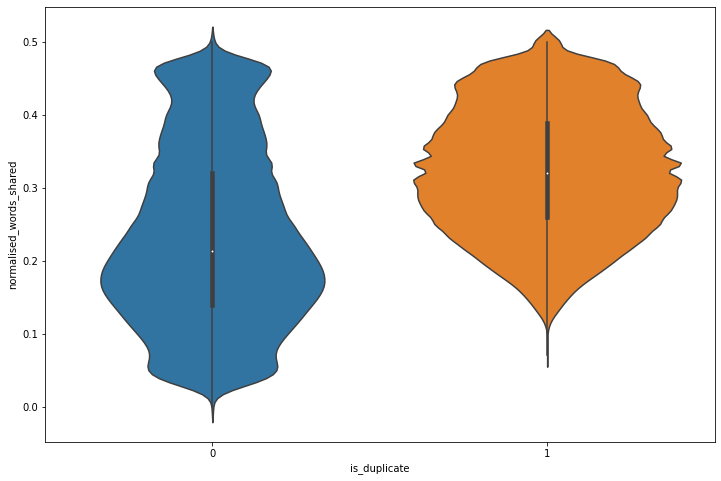

In [ ]:
plt.figure(figsize=(12, 8))
sns.violinplot(x = 'is_duplicate', y = 'normalised_words_shared', data = h4Df)

2) Tokenise words without stopwords

In [ ]:
stopWords = set(stopwords.words('english'))

def wordsShared(row):
    qn1 = row['question1'].lower()
    qn2 = row['question2'].lower()

    qn1Word = set(word_tokenize(qn1)) - stopWords
    qn2Word = set(word_tokenize(qn2)) - stopWords
    return len(qn1Word & qn2Word) / (len(qn1Word) + len(qn2Word))

h4Df["normalised_words_shared_without_stopwords"] = h4Df.apply(wordsShared, axis=1)

Getting mean and variance from the  data

In [ ]:
h4DfDuplicate = h4Df[h4Df['is_duplicate'] == 1]
h4DfNoDuplicate = h4Df[h4Df['is_duplicate'] == 0]

print("Duplicate")
print(h4DfDuplicate["normalised_words_shared_without_stopwords"].describe())
print()
print("Not duplicate")
print(h4DfNoDuplicate["normalised_words_shared_without_stopwords"].describe())

Duplicate
count    134378.000000
mean          0.353381
std           0.082063
min           0.090909
25%           0.285714
50%           0.357143
75%           0.416667
max           0.500000
Name: normalised_words_shared_without_stopwords, dtype: float64

Not duplicate
count    229468.000000
mean          0.245569
std           0.124131
min           0.000000
25%           0.142857
50%           0.235294
75%           0.333333
max           0.500000
Name: normalised_words_shared_without_stopwords, dtype: float64


Ploting the generic structure

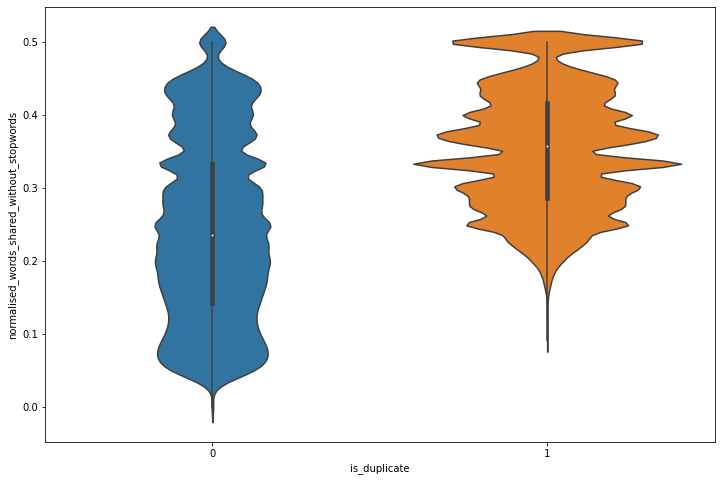

In [ ]:
plt.figure(figsize=(12, 8))
sns.violinplot(x = 'is_duplicate', y = 'normalised_words_shared_without_stopwords', data = h4Df)

### Conclusion

**For tokenised word**

Duplicate
* **mean:**          0.323786
* **25%:**           0.260870
* **75%:**           0.388889

Not duplicate
* **mean:**          0.232835
* **25%:**           0.139535
* **75%:**           0.320000

(+) Mean of duplicate and not duplicate is 0.090951 away from each other

(+) The mean of duplicate lies 0.003786 above the 75th percentile of not duplicate

(+) The mean of not duplicate lies 0.028035 away from the 25th percentile of duplicate

**For tokenised word on stopwords**
Duplicate
* **mean:**          0.353381
* **25%:**           0.285714
* **75%:**           0.416667

Not duplicate
* **mean:**          0.245569
* **25%:**           0.142857
* **75% :**          0.333333

(+) Mean of duplicate and not duplicate is 0.107812

(+) The mean of duplicate lies 0.020048 lies 75% above not duplicate

(+) The mean of not duplicate lies 0.040145 below the 25% 

Based on the data above, removing stop words from tokenised word is better than not removing.




#H6: Questions that are duplicates have a high percent of similar bag-of-ngrams (try 2-gram and 3-gram)


To validate is the same as H5, just using ngrams

Generate data for 2-gram

In [ ]:
h5Df = df.copy()

def getSimilarNGramWords(row, n):
    qn1 = row['question1'].lower()
    qn2 = row['question2'].lower()
    qn1Word = set(ngrams(word_tokenize(qn1), n))
    qn2Word = set(ngrams(word_tokenize(qn2), n))
    
    if len(qn1Word) + len(qn2Word) == 0:
        return 0

    return len(qn1Word & qn2Word) / (len(qn1Word) + len(qn2Word))

h5Df["normalised_2_gram_shared"] = h5Df.apply(lambda x: getSimilarNGramWords(x, 2), axis=1)

Finding mean and variance

In [ ]:
h5DfDuplicate = h5Df[h5Df['is_duplicate'] == 1]
h5DfNoDuplicate = h5Df[h5Df['is_duplicate'] == 0]

print("Duplicate")
print(h5DfDuplicate["normalised_2_gram_shared"].describe())
print()
print("Not duplicate")
print(h5DfNoDuplicate["normalised_2_gram_shared"].describe())

Duplicate
count    134378.000000
mean          0.188372
std           0.113506
min           0.000000
25%           0.100000
50%           0.166667
75%           0.266667
max           0.500000
Name: normalised_2_gram_shared, dtype: float64

Not duplicate
count    229468.000000
mean          0.107630
std           0.125866
min           0.000000
25%           0.000000
50%           0.058824
75%           0.166667
max           0.500000
Name: normalised_2_gram_shared, dtype: float64


Generate rought outline of data

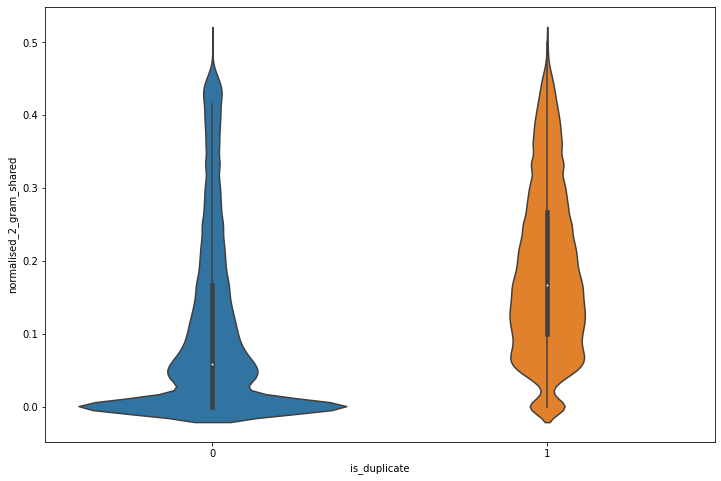

In [ ]:
plt.figure(figsize=(12, 8))
sns.violinplot(x = 'is_duplicate', y = 'normalised_2_gram_shared', data = h5Df)

Generate data for 3-gram

In [ ]:
h5Df["normalised_3_gram_shared"] = h5Df.apply(lambda x: getSimilarNGramWords(x, 3), axis=1)

Find mean or variance

In [ ]:
h5DfDuplicate = h5Df[h5Df['is_duplicate'] == 1]
h5DfNoDuplicate = h5Df[h5Df['is_duplicate'] == 0]

print("Duplicate")
print(h5DfDuplicate["normalised_3_gram_shared"].describe())
print()
print("Not duplicate")
print(h5DfNoDuplicate["normalised_3_gram_shared"].describe())

Duplicate
count    134378.000000
mean          0.118630
std           0.116724
min           0.000000
25%           0.000000
50%           0.088235
75%           0.187500
max           0.500000
Name: normalised_3_gram_shared, dtype: float64

Not duplicate
count    229468.000000
mean          0.068031
std           0.114006
min           0.000000
25%           0.000000
50%           0.000000
75%           0.090909
max           0.500000
Name: normalised_3_gram_shared, dtype: float64


Plot generate data

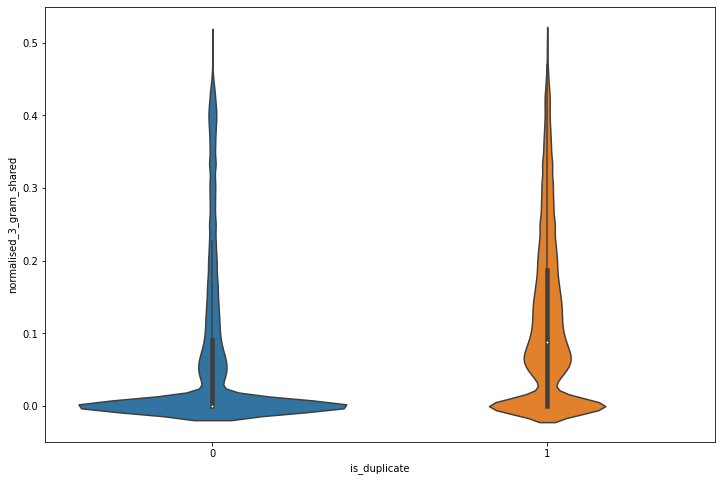

In [ ]:
plt.figure(figsize=(12, 8))
sns.violinplot(x = 'is_duplicate', y = 'normalised_3_gram_shared', data = h5Df)

### Conclusion

**For 2-gram word**

Duplicate
* **mean:**          0.188372
* **25%:**           0.100000
* **75%:**           0.266667

Not duplicate
* **mean:**          0.107630
* **25%:**           0.000000
* **75%:**           0.166667

(+) The mean has a difference of 0.0807
(+) The mean of duplicate lies 0.021705 above the 75th percentile of not duplicate
(-) The mean of not duplicate lies in the 25th - 75th percentile of duplicate

**For 3-gram word**

Duplicate
* **mean:**          0.118630
* **25%:**           0.000000
* **75%:**           0.187500

Not duplicate
* **mean:**          0.068031
* **25%:**           0.000000
* **75%:**           0.090909

(+) The mean has a difference of 0.050599
(+) The mean of duplicate lies 0.027721 above the  75th percentile of not duplicate
(-) The mean of not duplicate lies in the 25th - 75th percentile of duplicate


#H7: Stemming the words in the questions is good enough 


In [ ]:
from nltk.stem import LancasterStemmer
stemmer =  LancasterStemmer()

print(stemmer.stem('dictionaries'))


dict


In [ ]:
from gensim import models

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from gensim import models
import seaborn


from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, RegexpTokenizer
stop = stopwords.words('english')
alpha_tokenizer = RegexpTokenizer('[A-Za-z]\w+')

dfRahul2 = df.dropna()

In [ ]:
texts = np.concatenate([dfRahul2.question1.values, dfRahul2.question2.values])

In [ ]:
def process_sent(words, stem=False):
    words = words.lower()
    tokens = alpha_tokenizer.tokenize(words)
    for index, word in enumerate(tokens):
        if stem:
            tokens[index] = stemmer.stem(word)
        else:
            tokens[index] = word
    return tokens


In [ ]:
corpus_stemmed = [process_sent(sent, stem=True) for sent in texts]

In [ ]:
corpus = [process_sent(sent) for sent in texts]

In [ ]:
VECTOR_SIZE = 100



In [ ]:
min_count = 10
size = VECTOR_SIZE
window = 10

In [ ]:
model_stemmed = models.Word2Vec(corpus_stemmed, min_count=min_count, 
                                size=size, window=window)

In [ ]:
model = models.Word2Vec(corpus, min_count=min_count, 
                                size=size, window=window)

In [ ]:
model_stemmed.most_similar('tax')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('incom', 0.6686211228370667),
 ('pay', 0.6161524057388306),
 ('debt', 0.584846556186676),
 ('transact', 0.5660104155540466),
 ('exempt', 0.5648500919342041),
 ('landlord', 0.557068943977356),
 ('return', 0.5561150312423706),
 ('exc', 0.5514662265777588),
 ('asset', 0.5425033569335938),
 ('property', 0.5349326133728027)]

In [ ]:
q1 = dfRahul2.question1.values[200000:]
q2 = dfRahul2.question2.values[200000:]
Y = np.array(dfRahul2.is_duplicate.values)[200000:]

In [ ]:
def preprocess_check(words, stem=False):
    words = words.lower()
    tokens = alpha_tokenizer.tokenize(words)
    model_tokens = []
    for index, word in enumerate(tokens):
        if stem:
            stem_word = stemmer.stem(word)
            if stem_word in model_stemmed.wv.vocab:
                model_tokens.append(stem_word)
        else:
            if word in model.wv.vocab:
                model_tokens.append(word)
    return model_tokens

In [ ]:
old_err_state = np.seterr(all='raise')

def vectorize(words, words_2, model, num_features, stem=False):
    features = np.zeros((num_features), dtype='float32')
    words_amount = 0
    
    words = preprocess_check(words, stem)
    words_2 = preprocess_check(words_2, stem)
    for word in words: 
            words_amount = words_amount + 1
            features = np.add(features, model[word])
    for word in words_2: 
            words_amount = words_amount + 1
            features = np.add(features, model[word])
    try:
        features = np.divide(features, words_amount)
    except FloatingPointError:
        features = np.zeros(num_features, dtype='float32')
    return features  

In [ ]:
X_stem = []
for index, sentence in enumerate(q1):
    X_stem.append(vectorize(sentence, q2[index], model_stemmed, VECTOR_SIZE, True))
X_stem = np.array(X_stem)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
X = []
for index, sentence in enumerate(q1):
    X.append(vectorize(sentence, q2[index], model, VECTOR_SIZE))
X = np.array(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


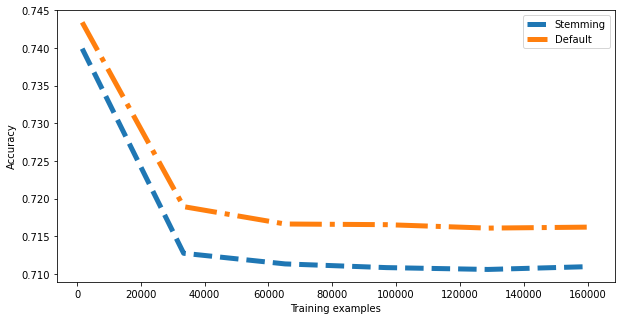

In [ ]:
results = []
title_font = {'size':'10', 'color':'black', 'weight':'normal',
                  'verticalalignment':'bottom'} 
axis_font = {'size':'10'}

plt.figure(figsize=(10, 5))
plt.xlabel('Training examples', **axis_font)
plt.ylabel('Accuracy',  **axis_font)
plt.tick_params(labelsize=10)

for X_set, name, lstyle in [
            (X_stem, 'Stemming', 'dashed'),
            (X, 'Default', 'dashdot'),
            ]:
    estimator = LogisticRegression(C = 1)
    cv = ShuffleSplit(n_splits=6, test_size=0.01, random_state=0)
    train_sizes=np.linspace(0.01, 0.99, 6)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_set, Y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    results.append({'preprocessing' : name, 'score' : train_scores_mean[-1]})
    plt.plot(train_sizes, train_scores_mean, label=name, linewidth=5, linestyle=lstyle)
   

plt.legend(loc='best')

Stemming showed worse result than default. This is because stemming reduces the amount of information, making one stem for the different word forms. Sometimes this is helpful, but sometimes this can bring noise to the model since some stems of the different words can be ambiguous, and the model can't be able to separate "playstation" and "play".

#H8: 5W1H is an appropriate way of getting the qn-qn buckets [for this it really depends on what most questions start with; can just recommend the top 5 qn-qn buckets and call the rest "others"]


# H9: Simple Accuracy is an appropriate metric for this dataset. [this might require a bit of non-coding research ... can just google tbh. Internet says F1 is nice but it would be good to have a strong justification]


Accuracy can be used for problems where the data is well balanced and not skewed.
Problem if it is unbalanced: If we have one class that appears 99% of the time (no) and another that only appears 1% of the time (yes), a no-classifier will be correct 99% of the time. However, this misses out the 1% from the other class. 

This is a problem if the cost of the yes class is very high, such as a cancer diagnosis. A false negative (no when it should have been a yes) would be very costly as it could cost patients their life.

With the dataset that we have, both similar and dissimilar classes are roughly equally distributed. The cost of a misclassification is also not very high. As such, we assign equal cost to false positives and false negatives.

Thus, with these considerations, simple accuracy is an appropriate metric.

#H10: Number of similar words between qn pairs (and related counts or number) can be used as hand-engineered features. This one is tricky coz it requires a lot of justification. Possibly come up with many and only experiments will tell whether they work or not

## Word share

In [ ]:
dfRahul1 = df.dropna()

from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

Text(0.5, 0, 'word_match_share')

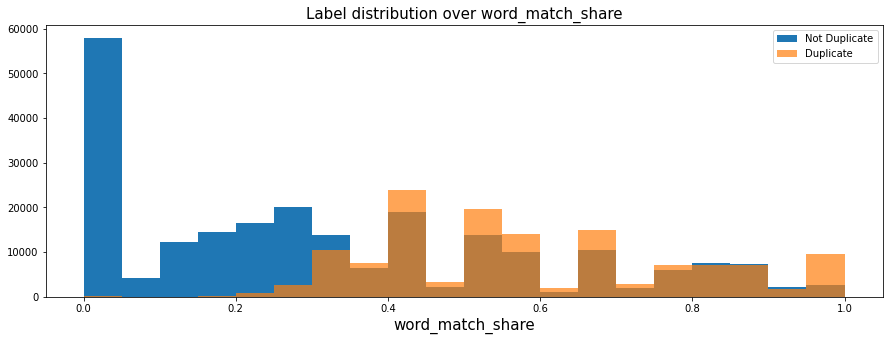

In [ ]:
plt.figure(figsize=(15, 5))
train_word_match = dfRahul1.apply(word_match_share, axis=1)
plt.hist(train_word_match[dfRahul1['is_duplicate'] == 0], bins=20, label='Not Duplicate')
plt.hist(train_word_match[dfRahul1['is_duplicate'] == 1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

We can see that this feature has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones.
But there is still a lot of overlap. It seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates. Hence we will try and improve this feature by using TF-IDF, by which we look at rare words occuring in both in pairs of question and compare the 2 methods.

## TF-IDF

In [ ]:
from collections import Counter



train_qs = pd.Series(dfRahul1['question1'].tolist() + dfRahul1['question2'].tolist()).astype(str)

def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [ ]:

print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])


Most common words and weights: 

[('the', 2.8688395257234497e-06), ('what', 3.44977472971015e-06), ('is', 3.969671708149736e-06), ('how', 4.825043907899562e-06), ('i', 4.949196497948558e-06), ('a', 5.018039853272515e-06), ('to', 5.163555624402964e-06), ('in', 5.3958969599516525e-06), ('of', 6.535563267520212e-06), ('do', 6.698910757110894e-06)]

Least common words and weights: 


[('coe?', 9.998000399920016e-05),
 ('approach.', 9.998000399920016e-05),
 ('sparta', 9.998000399920016e-05),
 ('misconceptions,', 9.998000399920016e-05),
 ('premam', 9.998000399920016e-05),
 ('laxmi,', 9.998000399920016e-05),
 ('saraswati,', 9.998000399920016e-05),
 ('gorbachev?', 9.998000399920016e-05),
 ('way).', 9.998000399920016e-05),
 ('hackforums.net?', 9.998000399920016e-05)]

In [ ]:
from nltk.corpus import stopwords


stops = set(stopwords.words("english"))

def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R


In [ ]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = dfRahul1.apply(tfidf_word_match_share, axis=1)
plt.hist(tfidf_train_word_match[dfRahul1['is_duplicate'] == 0].fillna(0), bins=20, label='Not Duplicate')
plt.hist(tfidf_train_word_match[dfRahul1['is_duplicate'] == 1].fillna(0), bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)


FloatingPointError: ignored

<Figure size 1080x360 with 0 Axes>

In [ ]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(dfRahul1['is_duplicate'], train_word_match))
print('TFIDF AUC:   ', roc_auc_score(dfRahul1['is_duplicate'], tfidf_train_word_match.fillna(0)))

**TF-IDF** actually got worse in terms of overall **AUC** in comparison to word share. Thus word share feature is better at separating the duplicate questions from the non-duplicate ones.

------
# Prelimary eda (archive)

MH1: Assuming that we use the number of similar words as a feature for our model. How many common words are there for each feature?

In [ ]:
dfMarcus1 = df.dropna()


def wordsShared(row):
    qn1Word = set(word_tokenize(row['question1'].lower()))
    qn2Word = set(word_tokenize(row['question2'].lower()))
    return len(qn1Word & qn2Word) / (len(qn1Word) + len(qn2Word))

dfMarcus1["normalised_words_shared"] = dfMarcus1.apply(wordsShared, axis=1)


plt.figure(figsize=(12, 8))
sns.violinplot(x = 'is_duplicate', y = 'normalised_words_shared', data = dfMarcus1)

MH2: Following on from MH1, will removing the stop words affect the our graph? Will this be a better feature than MH1?

In [ ]:
dfMarcus2 = df.dropna()
stopWords = set(stopwords.words('english'))

def wordsShared(row):
    qn1Word = set(word_tokenize(row['question1'].lower())) - stopWords
    qn2Word = set(word_tokenize(row['question2'].lower())) - stopWords
    return len(qn1Word & qn2Word) / (len(qn1Word) + len(qn2Word))

dfMarcus2["normalised_words_shared_without_stopwords"] = dfMarcus2.apply(wordsShared, axis=1)


plt.figure(figsize=(12, 8))
sns.violinplot(x = 'is_duplicate', y = 'normalised_words_shared_without_stopwords', data = dfMarcus2)

MH3: Based on 5w1h, how many questions will fall into the others pot

In [ ]:
startingWords = {}

def findStartingWord(string):
    string = word_tokenize(string.lower())
    if string[0] not in startingWords:
        startingWords[string[0]] = 0
    startingWords[string[0]] += 1


        

qnBank = qnBank.dropna()
qnBank["question"].apply(findStartingWord)

sortedStartingWord = sorted(startingWords.items(), key=lambda x: x[1], reverse=True)
top20 = sortedStartingWord[:20]
notTop20 = sortedStartingWord[20:]
notTop20Total = sum(map(lambda x: x[1], notTop20))

print("Highest number of starting wrd")
print(top20)
print("the others")
print(notTop20Total)

In [ ]:
totalQuestions = sum(startingWords.values())

normalisedQuestionCount = {}

for key, value in top20:
    normalisedQuestionCount[key] = round(value / totalQuestions * 100, 3)

normalisedQuestionCount["others"] = round(notTop20Total / totalQuestions * 100, 3)
normalisedQuestionCount

Based on the above, we could split it into mainly
`what`, `how`, `why`, `is`, `which`, `can`, `i`, `others`

Excluding `others`, the 7 categories will account for 81.83% of all unique questions

In [ ]:
isSame = 0
isDifferent = 0
isCorrect = 0
isIncorrect = 0
dfMarcus3 = df.dropna()

def checkStartingWord(row):
    global isSame, isDifferent, isIncorrect, isCorrect
    qn1Word = word_tokenize(row['question1'].lower())
    qn2Word = word_tokenize(row['question2'].lower())
    if qn1Word[0] == qn2Word[0]:
        isSame += 1
    else:
        isDifferent += 1

    estimate = 1 if qn1Word[0] == qn2Word[0] else 0
    if estimate == row["is_duplicate"]:
        isCorrect += 1
    else:
        isIncorrect += 1

dfMarcus3.apply(checkStartingWord, axis=1)
print("Has the same starting word: ", isSame, "(", isSame / (isSame + isDifferent) * 100, "%)")
print("Has the different starting word: ", isDifferent, "(", isDifferent / (isSame + isDifferent) * 100, "%)")
print()
print("Is correctly labelled: ", isCorrect, "(", isCorrect / (isCorrect + isIncorrect) * 100, "%)")
print("Is incorrectly labelled: ", isIncorrect, "(", isIncorrect / (isCorrect + isIncorrect) * 100, "%)")

MH4: If the 2 questions are duplicates, they should be the same sendiments

In [ ]:
dfMarcus4 = df.dropna()
qnBankCopy = qnBank.drop_duplicates(subset=["qid"]).sort_values(["qid"])
qnBankCopy = qnBankCopy.set_index("qid")
qnBankCopy["sendiment"] = qnBankCopy["question"].apply(SentimentIntensityAnalyzer().polarity_scores)

In [ ]:
def getSentiment(row):
    qn1 = qnBankCopy.loc[row["qid1"]]["sendiment"]["compound"] + 1
    qn2 = qnBankCopy.loc[row["qid2"]]["sendiment"]["compound"] + 1
    
    return abs(qn1 - qn2) / (qn1 + qn2)

dfMarcus4["q_sentiments_difference"] = dfMarcus4.apply(getSentiment, axis=1)

plt.figure(figsize=(12, 8))
sns.violinplot(x = 'is_duplicate', y = 'q_sentiments_difference', data = dfMarcus4)